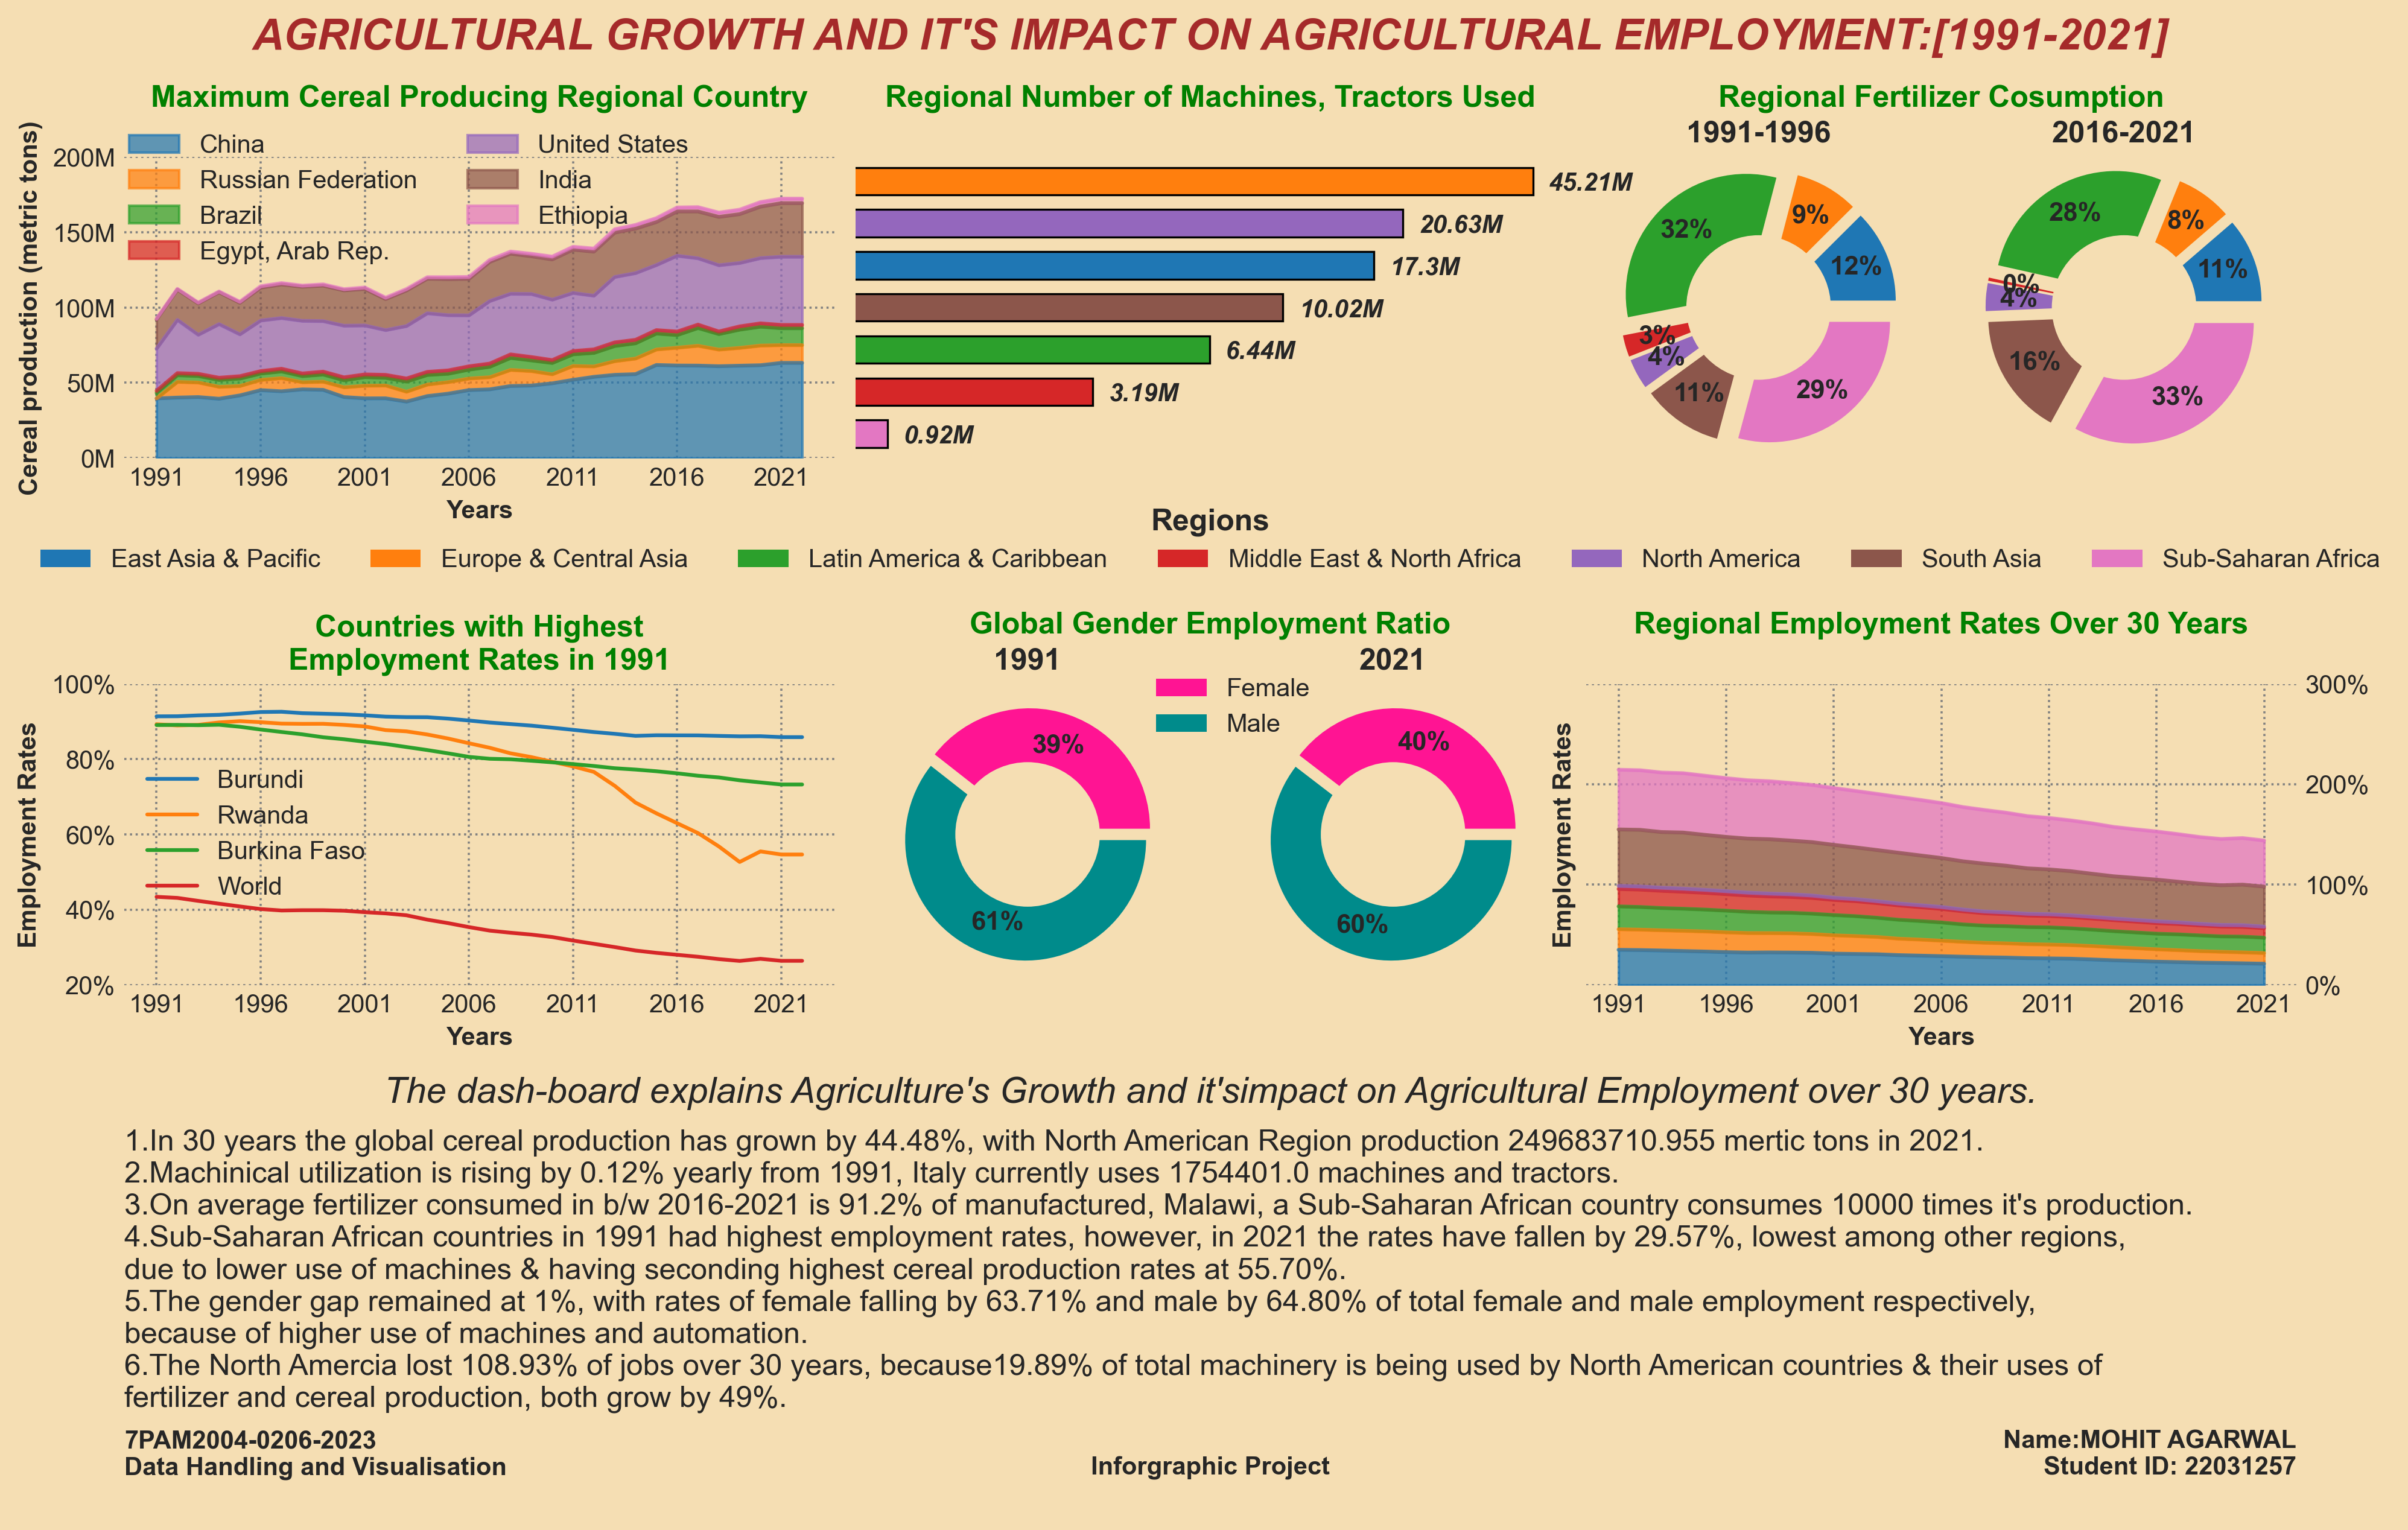

In [13]:
"""
7PAM2004-0206: Data Handling and Visualisation
Inforgraphic Project
------------------------------------------------------------------------------
Mohit Agarwal (Student ID-22031257)

Agriculture Growth and it's impact on employment 1991-2021
The growth is explained with the various indicators/factors, namely:
- Cereal production (metric tons)
- Agricultural machinery, tractors
- Fertilizer consumption (% of fertilizer production)
- Employment in agriculture (% of total employment)
    - Female & Male & Total

Link to datasets:
    Note: CSV Files ONLY!!!
- https://data.worldbank.org/indicator/AG.PRD.CREL.MT
- https://data.worldbank.org/indicator/AG.AGR.TRAC.NO
- https://data.worldbank.org/indicator/AG.CON.FERT.PT.ZS
- https://data.worldbank.org/indicator/SL.AGR.EMPL.ZS
    - https://data.worldbank.org/indicator/SL.AGR.EMPL.FE.ZS
    - https://data.worldbank.org/indicator/SL.AGR.EMPL.MA.ZS

Finally, all charts are put into a poster with brief summary.

Github Link:
- https://github.com/Mohitag94/DHV.git
"""


# importing required files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# selecting the style for plotting
plt.style.use("seaborn-v0_8-darkgrid")

# creating a indicators filename list
indicators_filenames = ["API_AG.PRD.CREL.MT_DS2_en_csv_v2_6304379.csv",
                        "API_AG.AGR.TRAC.NO_DS2_en_csv_v2_6305169.csv",
                        "API_AG.CON.FERT.PT.ZS_DS2_en_csv_v2_6305171.csv",
                        "API_SL.AGR.EMPL.ZS_DS2_en_csv_v2_6314846.csv",
                        "API_SL.AGR.EMPL.FE.ZS_DS2_en_csv_v2_6302174.csv",
                        "API_SL.AGR.EMPL.MA.ZS_DS2_en_csv_v2_6302453.csv"]

# creating a indicators' metadata filename list
indicators_metadata_filenames = \
    ["Metadata_Country_API_AG.PRD.CREL.MT_DS2_en_csv_v2_6304379.csv",
     "Metadata_Country_API_AG.AGR.TRAC.NO_DS2_en_csv_v2_6305169.csv",
     "Metadata_Country_API_AG.CON.FERT.PT.ZS_DS2_en_csv_v2_6305171.csv",
     "Metadata_Country_API_SL.AGR.EMPL.ZS_DS2_en_csv_v2_6314846.csv",
     "Metadata_Country_API_SL.AGR.EMPL.FE.ZS_DS2_en_csv_v2_6302174.csv",
     "Metadata_Country_API_SL.AGR.EMPL.MA.ZS_DS2_en_csv_v2_6302453.csv"]

# indicator names list
indicator_names = []

# colors for plotting
regional_colors = ["#1f77b4", "#ff7f0e", "#2ca02c",
                   "#d62728", "#9467bd", "#8c564b", "#e377c2"]
# regional colors allocated dictionary
regional_colors_dict = {}
# country colors allocated dictionary
country_color_dict = {}

# creating years values from 1991-2021
# with 1 year gap
years = [*map(str, np.arange(1991, 2022, 1))]
# with 3 year gap
years_3 = [*map(str, np.arange(1991, 2022, 3))]
# with 5 year gap
years_5 = [*map(str, np.arange(1991, 2022, 5))]
# with 10 year gap
years_10 = [*map(str, np.arange(1991, 2022, 10))]


def colors_allocation(cereal_regional_maxcountry_dict):
    """
    colors_allocation function, allocates each colors 
    to each country and region
    """

    # looping over the cereal_regiona_maxcountry_dicts keys
    for i, key in enumerate(cereal_regional_maxcountry_dict.keys()):
        # creating regional-color pair in the dictionary
        regional_colors_dict[key] = regional_colors[i]

    # looping over the regiona_colors_dicts keys
    for _, regional_key in enumerate(regional_colors_dict.keys()):
        # looping over the cereal_regiona_maxcountry_dicts keys
        for _, cereal_key in enumerate(cereal_regional_maxcountry_dict.keys()):
            # checking for same region
            if regional_key == cereal_key:
                # creating country-color part in the dictionary
                country_color_dict[cereal_regional_maxcountry_dict[cereal_key]
                                   ] = regional_colors_dict[regional_key]
# end of the colors_allocation function


def employment(df, df_female, df_male):
    """
    employment function find the actual employment rates in 
    agricultur among male and female, and returns them
    """

    # calculating female rate of employment overall
    female_overall_df = (100 * (df - df_male)) / (df_female - df_male)
    # calculating male rate of employment overall
    male_overall_df = 100 - female_overall_df
    # calculting female rate of employment in agriculture
    female_agr_df = female_overall_df * df / 100
    # calculting male rate of employment in agriculture
    male_agr_df = male_overall_df * df / 100

    return female_agr_df, male_agr_df
# end of employment  function


def regional_income_agg(df, aggfunc="mean", value=years):
    """
    regional_income_agg functions aggregates the merge file, 
    into two groups, regional and income, returns the same.
    """

    regional_df = df.pivot_table(values=value, index="Region",
                                 aggfunc=aggfunc)
    income_df = df.pivot_table(values=value, index="IncomeGroup",
                               aggfunc=aggfunc)

    # retiunig the aggregated dataframes
    return regional_df, income_df
# end of regional_income_agg function


def regional_max_countries(df, aggfunc="mean", value="2021"):
    """
    regional_max_countries function finds the countries with
    max values in each region and returns it.
    """

    # dictionary for region and country pair
    region_country_dict = {}

    # creating a pivot table with 2 levels - region and country name
    df_regional_countries = df.pivot_table(
        values=value, index=["Region", df.index], aggfunc=aggfunc)

    # grouping at level 0 to form a pair:region-max country
    for text in df_regional_countries.groupby(level=0).idxmax().values:
        # forming key-value pair - region-country
        region_country_dict[text[0][0]] = text[0][1]

    # returning the max counties in each region
    return region_country_dict
# end of regional_max_countries function


def eda(filename, file_metadata):
    """
    eda function, reads indicator and metadata csv files, 
    merge them, drops unwanted columns, and index with no data entries.

    Non-string nan's values are filled using introplate feature of pandas.

    Returns, three files, indicator, merged file, indicator transpose, in 
    between the time period of 1991-2021
    """

    # reading the indicator file
    df = pd.read_csv(filename, skiprows=[0, 1, 2, 3])
    # reading the metadatafile
    df_metadata = pd.read_csv(file_metadata)

    # extracting the indicator name
    indicator_names.append(df["Indicator Name"].values[0])

    # droping unnecessary columns from df, and df_metadata
    df.drop(columns=["Indicator Name", "Indicator Code",
            df.columns[-1]], axis="columns", inplace=True)
    df_metadata.drop(columns=[df_metadata.columns[-1],
                              df_metadata.columns[-2],
                              df_metadata.columns[-3]],
                     axis="columns", inplace=True)

    # merging the files - indicator and metadata
    df_merge = df.merge(df_metadata, on="Country Code", how="inner")

    # setting the country name as index in merged file and df
    df_merge.set_index("Country Name", inplace=True, drop=True)
    df.set_index("Country Name", inplace=True, drop=True)

    # droping the country code columns from the merged file and df
    df_merge.drop(columns="Country Code", axis="columns", inplace=True)
    df.drop(columns="Country Code", axis="columns", inplace=True)

    # droping the index with no entry
    df.dropna(axis="index", how="all", inplace=True)

    # merging the indicator file with metadata file
    df_merge.dropna(axis="index", how="all", inplace=True)

    # filling the nan values in df through interpolation
    df.interpolate(axis="columns", inplace=True)

    # changing the values in df_merge with df's
    df_merge.iloc[:, :-2] = df.copy()

    # taking a tranpose of the df
    df_tranpose = df.transpose()
    # renaming the index name
    df_tranpose.rename_axis("Years", inplace=True)

    # returing the values from 1991-2021.
    return df.loc[:, "1991":], df_merge.loc[:, "1991":], \
        df_tranpose.loc["1991":, :]
# end of eda function


# calling eda function for indicators...
# cereal productio
cereal_df, cereal_df_merge, cereal_df_tranpose = eda(
    indicators_filenames[0], indicators_metadata_filenames[0])
# machinery, tractors
machinery_df, machinery_df_merge, machinery_df_tranpose = eda(
    indicators_filenames[1], indicators_metadata_filenames[1])
# fertilizer consumped
fertilizer_df, fertilizer_df_merge, fertilizer_df_tranpose = eda(
    indicators_filenames[2], indicators_metadata_filenames[2])
# total employment rate
emp_df, emp_df_merge, emp_df_tranpose = eda(
    indicators_filenames[3], indicators_metadata_filenames[3])
# female employment rate
female_emp_df, female_emp_df_merge, female_emp_df_tranpose = eda(
    indicators_filenames[4], indicators_metadata_filenames[4])
# male employment rate
male_emp_df, male_emp_df_merge, male_emp_df_tranpose = eda(
    indicators_filenames[5], indicators_metadata_filenames[5])


# creating regiona dataframe for each indicators
# cereal production...
# creating a max country cereal through regional_max_countries function
cereal_regional_maxcountry_dict = regional_max_countries(cereal_df_merge)
cereal_max_countries_df = \
    cereal_df.loc[cereal_regional_maxcountry_dict.values(), :]
# calling regional_income_agg funcion for cereal
cereal_regional_df, _ = regional_income_agg(cereal_df_merge)

# calling colors_allocation function
colors_allocation(cereal_regional_maxcountry_dict)

# machinery..
# calling region_income_agg function for machinery
machinery_regional_df, machinery_income_df = \
    regional_income_agg(machinery_df_merge, aggfunc="sum", value=years_10)
# calculating toal in each region
machinery_regional_df["Total"] = machinery_regional_df.sum(
    axis="columns")
# adding color list for plotting
machinery_regional_df["Colors"] = machinery_regional_df.index.map(
    regional_colors_dict)
# sorting in ascending order
machinery_regional_df.sort_values(by="Total", inplace=True)

# fertilizer...
# calling region_income_agg function for fertilizer
fertilizer_regional_df, fertilizer_income_df = \
    regional_income_agg(fertilizer_df_merge, aggfunc="median")
# adding color list for plotting
fertilizer_regional_df["Colors"] = fertilizer_regional_df.index.map(
    regional_colors_dict)

# employment
# calling the employment function
female_actual_emp_df, male_actual_emp_df = employment(
    emp_df, female_emp_df, male_emp_df)
# replacing values in female and male merge dataframes
female_emp_df_merge.loc[:, years] = female_actual_emp_df
male_emp_df_merge.loc[:, years] = male_actual_emp_df
# creating a max country cereal through regional_max_countries function
emp_regional_maxcountry_dict = regional_max_countries(emp_df_merge)
emp_max_countries_df = \
    emp_df.loc[emp_regional_maxcountry_dict.values(), :]
# calling region_income_agg function for employment
emp_regional_df, _ = regional_income_agg(emp_df_merge)
# creating a world dataframe for female and male - combined
female_male_world_df = pd.concat([female_actual_emp_df.loc["World", :],
                                  male_actual_emp_df.loc["World", :]],
                                 axis="columns", keys=["Female", "Male"])


# plotting...
# initializing the figure
fig = plt.figure(dpi=300, figsize=(12, 8), facecolor="wheat")
# setting the axis off - axis not display
plt.axis("off")

# creating a grid for subplotting
g = gridspec.GridSpec(47, 30, wspace=0.4, hspace=0.4)

# subplot for project title
title_ax = plt.subplot(g[:3, :])
# placing the title
title_ax.set_title(f"AGRICULTURAL GROWTH AND IT'S IMPACT ON"
                   " AGRICULTURAL EMPLOYMENT:[1991-2021]",
                   fontsize="xx-large",
                   fontweight="black",
                   color="brown",
                   loc="center",
                   fontstyle="oblique")
# setting axis off
title_ax.axis('off')

# subplot for cereal production
cereal_ax = plt.subplot(g[3:13, :10])
# plotting the graph in the subplot
cereal_fig = (cereal_max_countries_df/1e+07).T.plot(ax=cereal_ax,
                                                    kind="area",
                                                    alpha=0.7,
                                                    color=country_color_dict)
# cereating a list for cereal labels
cereal_labels = []
# looping over the default y-axis used in the plot
for label in cereal_ax.get_yticks().tolist():
    # creating a new list of lables for y-axis
    cereal_labels.append(str(int(label))+"M")
# setting the y-axis ticks with the default ticks pos
cereal_ax.set_yticks(cereal_ax.get_yticks().tolist())
# putting the new labels in the y-axis
cereal_ax.set_yticklabels(cereal_labels)
# setting the y-axis label name
cereal_ax.set_ylabel(indicator_names[0], fontsize=10, fontweight="semibold")
# setting the x-axis label name
cereal_ax.set_xlabel("Years", fontsize=10, fontweight="semibold")
# changing the labels size on both axis
cereal_ax.tick_params(axis="both", which="both", labelsize=10)
# setting facecolor same as the whole figure
cereal_ax.set_facecolor("wheat")
# editing the grid
cereal_ax.grid(color="grey", linestyle=":", linewidth=0.85)
# setting title for the cereal plot
cereal_ax.set_title(label=f"Maximum Cereal Producing Regional Country",
                    loc="center",
                    fontweight="semibold",
                    color="green",
                    fontsize="large",
                    pad=20)
# editing the legend
cereal_ax.legend(loc="upper left",
                 ncols=2,
                 bbox_to_anchor=(-0.025, 1.15),
                 alignment="left",
                 fontsize="medium")


# subplot for cereal production
machinery_ax = plt.subplot(g[3:13, 10:20])
# plotting the bar graph
bar = machinery_regional_df.iloc[:, -2].plot(kind="barh",
                                             stacked=True,
                                             ax=machinery_ax,
                                             logx=True,
                                             edgecolor="black",
                                             align="center",
                                             width=0.65,
                                             linewidth=0.8,
                                             color=machinery_regional_df.
                                             iloc[:, -1])
# setting facecolor same as the whole figure
machinery_ax.set_facecolor("wheat")
# hiding the frid
machinery_ax.grid(False)
# hiding the axis
machinery_ax.axis("off")
# setting the title for the plot
machinery_ax.set_title(label="Regional Number of Machines, Tractors Used",
                       loc="center",
                       fontweight="semibold",
                       color="green",
                       fontsize="large",
                       pad=20)
# for loop over range of numbers of regions
for i in range(len(machinery_regional_df)):
    # creating a text for machinery used
    text = str(np.round(machinery_regional_df.iloc[:,
                                                   -2].
                        iloc[i]/1000000, 2)) \
        + "M"
    # putting the text next to the bar
    bar.text((machinery_regional_df.iloc[:, -2].iloc[i] +
              machinery_regional_df.iloc[:, -2].iloc[i]/10),
             i,
             text,
             ha="left",
             va="center_baseline",
             fontsize="medium",
             fontweight="demi",
             fontstyle="oblique",
             animated=True)
# end of for loop


# subplot for fertilizer
fertilizer_ax = plt.subplot(g[3:13, 20:30])
# hiding the grid
fertilizer_ax.axis("off")
# setting the title name for the pie charts
fertilizer_ax.set_title("Regional Fertilizer Cosumption",
                        pad=20,
                        loc="center",
                        fontweight="semibold",
                        color="green",
                        fontsize="large")
# subplot for 1991 fertilizer pie chart
fertilizer_ax_1991 = plt.subplot(g[3:13, 20:25])
# plotting the pie chart for first five years
fertilizer_regional_df.loc[:, "1991":"1996"].\
    mean(axis="columns").plot(ax=fertilizer_ax_1991,
                              kind="pie",
                              labeldistance=None,
                              legend=False,
                              explode=[
                                  0.15]*len(fertilizer_regional_df.index),
                              textprops={'fontsize': 10.5,
                                         "fontweight": "semibold"},
                              autopct="%.0f%%",
                              pctdistance=0.725,
                              colors=fertilizer_regional_df.iloc[:, -1])
# creating the circle
centre_circle_1991 = plt.Circle((0, 0), 0.60, fc='wheat')
# getting the current plot
pie_1991_fig = plt.gcf()
# plotting the circle over the pie chart
pie_1991_fig.gca().add_artist(centre_circle_1991)
# setting title
fertilizer_ax_1991.set_title("1991-1996", loc="center",
                             fontweight="semibold")
# subplot for 1991 fertilizer pie chart
fertilizer_ax_2021 = plt.subplot(g[3:13, 25:])
# plotting pie chart for last fist years
fertilizer_regional_df.loc[:, "2016":"2021"].\
    mean(axis="columns").plot(ax=fertilizer_ax_2021,
                              kind="pie",
                              labeldistance=None,
                              legend=False,
                              explode=[
                                  0.15]*len(fertilizer_regional_df.index),
                              textprops={'fontsize': 10.5,
                                         "fontweight": "semibold"},
                              autopct="%.0f%%",
                              pctdistance=0.725,
                              colors=fertilizer_regional_df.iloc[:, -1])
# creating a circle
centre_circle_2021 = plt.Circle((0, 0), 0.60, fc='wheat')
# getting current plot
pie_2021_fig = plt.gcf()
# drawing circle over the pie chart
pie_2021_fig.gca().add_artist(centre_circle_2021)
# setting title
fertilizer_ax_2021.set_title("2016-2021", loc="center",
                             fontweight="semibold")


# subplot for putting global legend
legend_ax = plt.subplot(g[14:17, :])
# hiding the axis
legend_ax.axis("off")
# putting the legend on the subplot
regional_legend = legend_ax.legend(*fertilizer_ax_2021.
                                   get_legend_handles_labels(),
                                   loc="center",
                                   ncols=7,
                                   fontsize="medium",
                                   title="Regions",
                                   title_fontproperties=dict(
                                       weight="semibold", size="large"),
                                   alignment="center")

# subplot max_countries employment rates
emp_max_countries_ax = plt.subplot(g[20:30, :10])
# plotting top 3 countries
emp_df.sort_values(by="1991", ascending=False).iloc[:3, :].T.plot(
    ax=emp_max_countries_ax)
# potting the world rates
emp_df.loc["World", :].T.plot(ax=emp_max_countries_ax, label="World")
# y-axis ticks labels list
emp_labels = []
# looping over the ticks on y-axis
for label in emp_max_countries_ax.get_yticks().tolist():
    # creating the new ticklabels list for y-axis
    emp_labels.append(str(int(label))+"%")
# setting the default ticks in place
emp_max_countries_ax.set_yticks(emp_max_countries_ax.get_yticks().tolist())
# setting the tickslabels with new labels
emp_max_countries_ax.set_yticklabels(emp_labels, fontsize=10)
# setting y-axis labels name
emp_max_countries_ax.set_ylabel(
    "Employment Rates", fontsize=10, fontweight="semibold")
# setting x-axis labels name
emp_max_countries_ax.set_xlabel("Years", fontsize=10, fontweight="semibold")
# changing the labels size on both axis
emp_max_countries_ax.tick_params(axis="both", which="both", labelsize=10)
# setting the facecolor same as whole plot
emp_max_countries_ax.set_facecolor("wheat")
# editting the grid
emp_max_countries_ax.grid(color="grey", linestyle=":", linewidth=0.85)
# setting the title
emp_max_countries_ax.set_title(label=f"Countries with Highest"
                               "\nEmployment Rates in 1991",
                               loc="center",
                               fontweight="semibold",
                               color="green",
                               fontsize="large")
# setting the legend
emp_max_countries_ax.legend(loc="best",
                            ncols=1,
                            fontsize="medium")


# subplot for employment ratios
emp_ratio_ax = plt.subplot(g[20:30, 10:20])
# setting the title for entire plot
emp_ratio_ax.set_title(f"Global Gender Employment Ratio",
                       pad=20,
                       loc="center",
                       fontweight="semibold",
                       color="green",
                       fontsize="large")
# hidding the axis
emp_ratio_ax.axis("off")
# subplot for 1991 employment ratio
emp_ratio_ax_1991 = plt.subplot(g[20:30, 10:15])
# ploting the pie chart for 1991
female_male_world_df.loc["1991"].plot(kind="pie",
                                      ax=emp_ratio_ax_1991,
                                      autopct="%.0f%%",
                                      explode=[0.05, 0.05],
                                      labeldistance=None,
                                      pctdistance=0.725,
                                      textprops={'fontsize': 10.5,
                                                 "fontweight": "semibold"},
                                      colors=["deeppink", "darkcyan"])
# hiding the axis
emp_ratio_ax_1991.axis("off")
# creating a circle
emp_centre_circle_1991 = plt.Circle((0, 0), 0.60, fc='wheat')
# getting the current plot
emp_pie_1991_fig = plt.gcf()
# drawing the circle over the pie chart - 1991
emp_pie_1991_fig.gca().add_artist(emp_centre_circle_1991)
# setting the title
emp_ratio_ax_1991.set_title("1991",
                            loc="center",
                            fontweight="semibold")
# subplot for 2021 employment ratio
emp_ratio_ax_2021 = plt.subplot(g[20:30, 15:20])
# plotting the pie chart for 2021
female_male_world_df.loc["2021"].plot(kind="pie",
                                      ax=emp_ratio_ax_2021,
                                      autopct="%.0f%%",
                                      explode=[0.05, 0.05],
                                      labeldistance=None,
                                      pctdistance=0.75,
                                      textprops={'fontsize': 10.5,
                                                 "fontweight": "semibold"},
                                      colors=["deeppink", "darkcyan"])
# hiding the axis
emp_ratio_ax_2021.axis("off")
# creating a circle
emp_centre_circle_2021 = plt.Circle((0, 0), 0.60, fc='wheat')
# getting the current fig
emp_pie_2021_fig = plt.gcf()
# drawing a circle over the pie chart
emp_pie_2021_fig.gca().add_artist(emp_centre_circle_2021)
# setting the title
emp_ratio_ax_2021.set_title("2021",
                            loc="center",
                            fontweight="semibold")
# setting a legend
emp_ratio_ax_2021.legend(["Female", "Male"],
                         bbox_to_anchor=(0.3, 0.75),
                         fontsize="medium")


# subplot for regional emploment rates
emp_regional_ax = plt.subplot(g[20:30, 20:])
# plotting the graph
emp_regional_fig = emp_regional_df.T.plot(kind="area",
                                          alpha=.75,
                                          ax=emp_regional_ax,
                                          legend=False,
                                          color=regional_colors_dict)
# setting y-axis on the right
emp_regional_fig.tick_params(axis="y",
                             which="both",
                             labelleft=False,
                             labelright=True)
# setting the facecolor same as whole graph
emp_regional_ax.set_facecolor("wheat")
# editing the grid
emp_regional_ax.grid(color="grey",
                     linestyle=":",
                     linewidth=0.85)
# list of yticks-labes for the graph
emp_regional_labels = []
# looping over the current list of ticks
for label in emp_regional_ax.get_yticks().tolist():
    # creating new ticks labels
    emp_regional_labels.append(str(int(label))+"%")
# setting the ticks with default pos
emp_regional_ax.set_yticks(emp_regional_ax.get_yticks().tolist())
# setting ticks labels with new labels
emp_regional_ax.set_yticklabels(emp_regional_labels)
# setting the y-axis label name
emp_regional_ax.set_ylabel("Employment Rates",
                           fontsize=10,
                           fontweight="semibold")
# setting the x-axis label name
emp_regional_ax.set_xlabel("Years",
                           fontsize=10,
                           fontweight="semibold")
# setting the label size
emp_regional_ax.tick_params(axis="both", which="both", labelsize=10)
# setting the title
emp_regional_ax.set_title(f"Regional Employment Rates Over 30 Years",
                          pad=20,
                          loc="center",
                          fontweight="semibold",
                          color="green",
                          fontsize="large")


# subplot for graph summary
summary_ax = plt.subplot(g[34:42, :])
# setting the title for the summary
summary_ax.set_title(f"The dash-board explains Agriculture's Growth and it's"
                     "impact on Agricultural Employment over 30 years.",
                     loc="center",
                     fontstyle="oblique",
                     fontsize="x-large")
# summary text for the graph
summary_text = f"1.In 30 years the global cereal production has grown by"\
    " 44.48%, with North American Region production 249683710.955 mertic"\
    " tons in 2021."\
    "\n2.Machinical utilization is rising by 0.12% yearly from"\
    " 1991, Italy currently uses 1754401.0 machines and tractors."\
    "\n3.On average fertilizer consumed in b/w 2016-2021 is"\
    " 91.2% of manufactured, Malawi, a Sub-Saharan African"\
    " country consumes 10000 times it's production."\
    "\n4.Sub-Saharan African countries in 1991 had highest"\
    " employment rates, however, in 2021 the rates have fallen"\
    " by 29.57%, lowest among other regions,\ndue to lower"\
    " use of machines & having seconding highest cereal"\
    " production rates at 55.70%."\
    "\n5.The gender gap remained at 1%, with rates of female"\
    " falling by 63.71% and male by 64.80% of total female and male"\
    " employment respectively,\nbecause of higher use of machines and"\
    " automation."\
    "\n6.The North Amercia lost 108.93% of jobs over 30 years, because"\
    "19.89% of total machinery is being used by North American countries &"\
    " their uses of\nfertilizer and cereal production, both grow by 49%."
# putting the text in the graph
summary_ax.text(0, 0.9525,
                summary_text,
                fontsize=11.85,
                va="top",
                ha="left",
                wrap=True,
                ma="left")
# hiding the axis
summary_ax.axis("off")

# subplot for footer of the graph
footer_ax = plt.subplot(g[46, :])
# hiding the axis
footer_ax.axis("off")
# setting the left title
footer_ax.set_title(f"7PAM2004-0206-2023\nData Handling and Visualisation",
                    loc="left",
                    fontsize="medium",
                    fontweight="semibold")
# setting the centeral title
footer_ax.set_title("Inforgraphic Project",
                    loc="center",
                    fontsize="medium",
                    fontweight="semibold")
# setting the right title - name & id
footer_ax.set_title(f"Name:MOHIT AGARWAL\nStudent ID: 22031257",
                    loc="right",
                    fontsize="medium",
                    fontweight="semibold")

# adding adjustments to the subplots
plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                    hspace=0, wspace=0)

# showing the plot
plt.show()